# **BTC forecating**
## **Student of group KA-03mp Sobol A. A.**
# **Import library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

import datetime
from pandas.tseries.offsets import DateOffset
from pandas.tseries.offsets import MonthEnd

from scipy import stats
import itertools

import gc
import warnings
warnings.filterwarnings("ignore")

plt.style.use("fivethirtyeight")
import sys
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Download Data**


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab_data/')

In [ ]:
#Finam.ru data 1 minutes. 2015-2021 years.
path = {
    "2015": "/content/drive/MyDrive/Colab_data/Dataset BTC/BTC_2015.csv",
    "2016": "/content/drive/MyDrive/Colab_data/Dataset BTC/BTC_2016.csv",
    "2017": "/content/drive/MyDrive/Colab_data/Dataset BTC/BTC_2017.csv",
    "2018": "/content/drive/MyDrive/Colab_data/Dataset BTC/BTC_2018.csv",
    "2019": "/content/drive/MyDrive/Colab_data/Dataset BTC/BTC_2019.csv",
    "2020": "/content/drive/MyDrive/Colab_data/Dataset BTC/BTC_2020.csv",
    "2021.04.06": "/content/drive/MyDrive/Colab_data/Dataset BTC/BTC_2021.01.01 - 2021.04.06.csv"
}

df = pd.concat((pd.read_csv(path[f]) for f in path))

In [ ]:
def reshape_dates_finam(data):
    '''
    Reshape dates from finam.ru in pandas Datetime;
    Rename columns at standart;
    Set timestamps index.
    '''

    data['<TIME>'] = data['<TIME>'].astype(str).str.zfill(6)
    data['Timestamp'] = data[['<DATE>', '<TIME>']].apply(lambda x: ''.join(x.astype(str)), axis=1)
    data.drop(['<DATE>', '<TIME>'], axis=1, inplace=True)
    data['Timestamp'] = pd.to_datetime(data['Timestamp'].astype(int), format='%Y%m%d%H%M%S')
    data.rename(columns={'<OPEN>':'Open',
                        '<HIGH>':'High',
                        '<LOW>':'Low',
                        '<CLOSE>':'Close',
                        '<VOL>':'Volume'}, inplace=True)
    data.set_index('Timestamp', inplace=True)
    return data

In [ ]:
def np_vwap(h, l, v):
    '''
    h - High
    l - Low
    v - Volume
    '''
    return np.cumsum(v*(h+l)/2) / np.cumsum(v)

def vwap_by_period(h, l, v, p):
    data = pd.Series(np.zeros(h.shape), name="My_VWAP")
    for i in range(0, h.shape[0], p):
        data[i:i+p] = np_vwap(h[i:i+p], l[i:i+p], v[i:i+p])
    return data

In [ ]:
df = reshape_dates_finam(df)

# It's just typical price. But it's temporarily , becouse 
# I don't know what a period for wvap to take better. 
df["Weighted_Price"] = (df["High"] + df["Low"] + df["Close"]) / 3
df.tail()

,Open,High,Low,Close,Volume,Weighted_Price
Timestamp,,,,,,
2021-04-06 23:57:00,58058.15,58086.48,58057.82,58078.22,1,58074.173333
2021-04-06 23:58:00,58078.22,58078.22,58025.01,58030.87,4,58044.700000
2021-04-06 23:59:00,58030.64,58030.64,58011.37,58011.38,2,58017.796667
2021-04-07 00:00:00,58011.38,58021.70,58011.37,58019.98,3,58017.683333
2021-04-07 00:01:00,58021.67,58031.54,58013.51,58018.31,2,58021.120000


In [ ]:
# Data tick for tick. 50M timestamps for ticks at 10 years.
# May be need to prepare to OHCV shape. 
df = pd.read_csv('/content/drive/MyDrive/Colab_data/bitstampUSD.csv.gz', compression='gzip')
df['1315922016'] = pd.to_datetime(df['1315922016'], unit="s")
df.rename(columns={
    "1315922016": "Timestamp",
    "5.800000000000": "Price",
    "1.000000000000": "Volume"
}, inplace=True)
df.set_index("Timestamp", inplace=True)


In [ ]:
df['Price_by_Volume'] = df['Price'] * df['Volume']
df_vwap = df.resample('T').sum()
df_vwap['Weighted_Price'] = df_vwap['Price_by_Volume'] / df_vwap['Volume']

In [ ]:
df_vwap.tail()

,Price,Volume,Weighted_Price,Price_by_Volume
Timestamp,,,,
2021-04-08 10:13:00,395523.80,1.087410,56500.074196,61438.745682
2021-04-08 10:14:00,2486847.25,13.996192,56529.421266,791196.655175
2021-04-08 10:15:00,1752255.45,4.312484,56522.777472,243753.574048
2021-04-08 10:16:00,2768386.28,6.004146,56497.758087,339220.771841
2021-04-08 10:17:00,282298.79,0.239955,56461.550320,13548.231872


In [ ]:
df_ohlc = df['Price'].resample('T').ohlc()
df_ohlc = df_ohlc.join(df_vwap[['Volume', 'Price_by_Volume', 'Weighted_Price']])

In [ ]:
df_ohlc

,open,high,low,close,Volume,Price_by_Volume,Weighted_Price
Timestamp,,,,,,,
2011-09-13 13:53:00,5.83,6.00,5.83,6.00,24.000000,143.390000,5.974583
2011-09-13 13:54:00,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2011-09-13 13:55:00,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2011-09-13 13:56:00,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2011-09-13 13:57:00,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...
2021-04-08 10:13:00,56523.80,56523.80,56500.00,56500.00,1.087410,61438.745682,56500.074196
2021-04-08 10:14:00,56512.63,56548.00,56500.95,56522.17,13.996192,791196.655175,56529.421266
2021-04-08 10:15:00,56515.69,56555.11,56506.13,56507.42,4.312484,243753.574048,56522.777472


In [ ]:
df_ohlc['2020-12-30 23:56:00':'2020-12-30 23:59:00']

,open,high,low,close,Volume,Price_by_Volume,Weighted_Price
Timestamp,,,,,,,
2020-12-30 23:56:00,28801.47,28829.42,28785.64,28829.42,0.965221,27804.572129,28806.429798
2020-12-30 23:57:00,28829.42,28863.90,28829.42,28857.06,2.368831,68332.350629,28846.441863
2020-12-30 23:58:00,28850.49,28900.52,28850.49,28882.82,2.466590,71232.784464,28879.056266
2020-12-30 23:59:00,28910.54,28911.52,28867.60,28881.30,7.332773,211870.912659,28893.695831


# **Exploratory data analysis**

Text(0.07, 1, 'Missing data check')

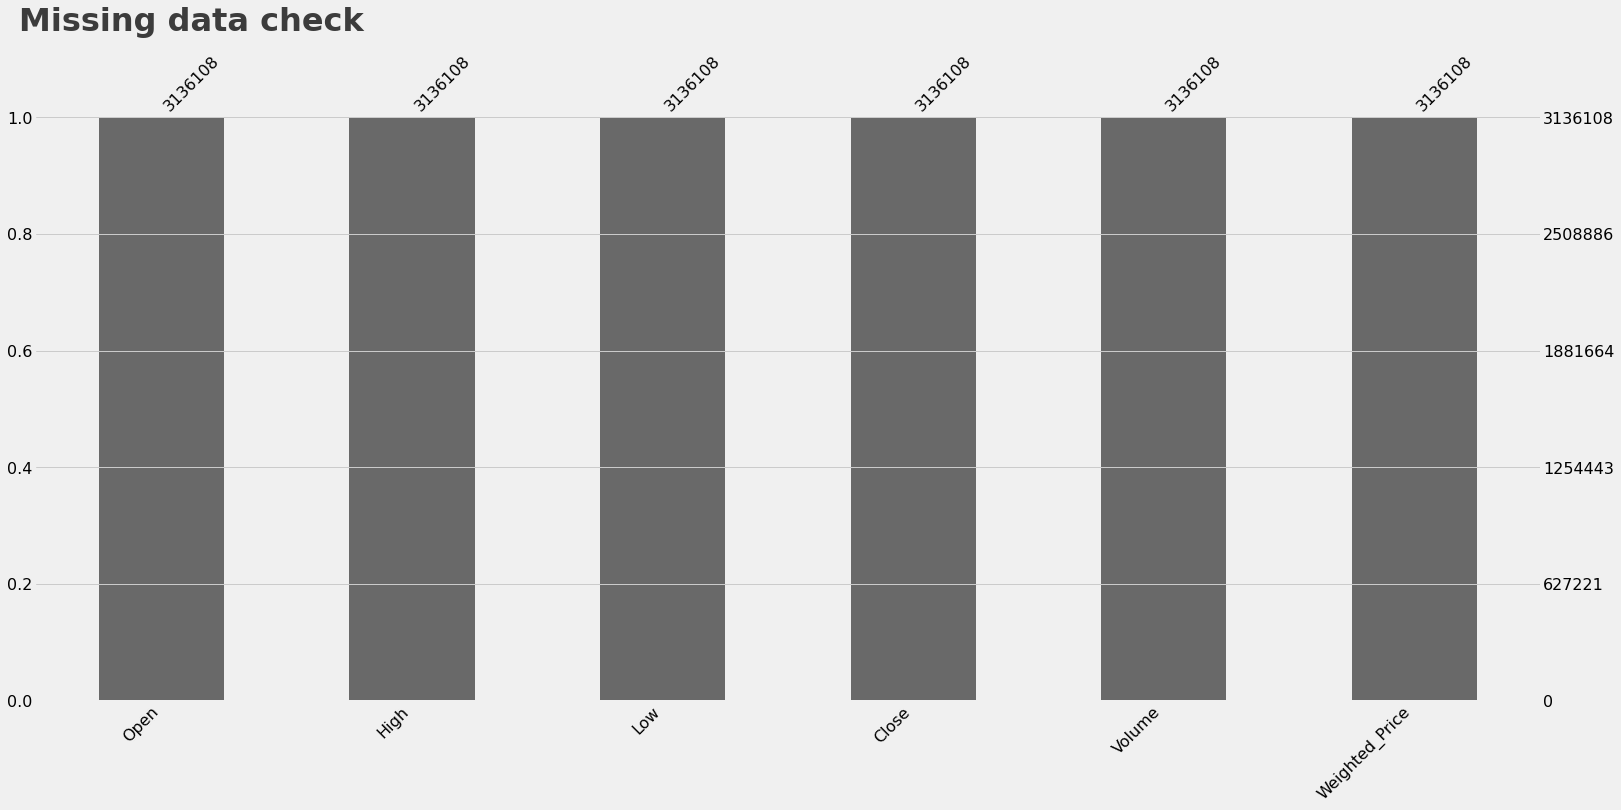

In [ ]:
ax, fig = plt.subplots(figsize=(10,5))
msno.bar(df)
ax.text(0.07,1, s="Missing data check", fontsize=32, weight="bold", alpha=0.75)

Plot opening and closing price

In [ ]:
df_hour = df.resample("h").mean()

Text(2015-06-30, 49000, 'Hourly opening and closing price of Bitcoin (2015-2021)')

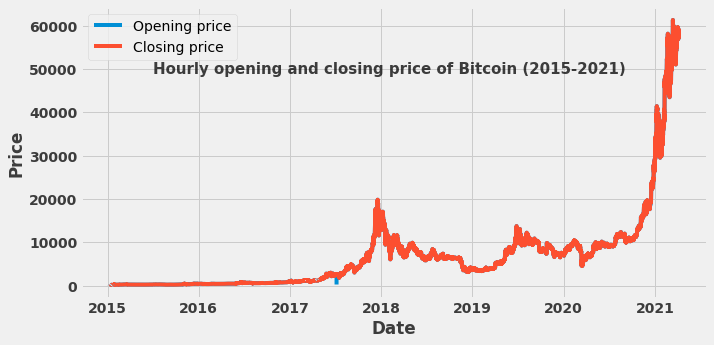

In [ ]:
ax, fig = plt.subplots(figsize = (10,5))

plt.plot(df_hour["Open"], label="Opening price")
plt.plot(df_hour["Close"], label="Closing price")
# plt.plot(df_hour["Cost"], label="Cost")

plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Date",alpha=0.75, weight="bold")
plt.ylabel("Price",alpha=0.75, weight="bold")

plt.legend()

plt.text(x=datetime.date(2015, 6, 30), y=49000, s="Hourly opening and closing price of Bitcoin (2015-2021)",
fontsize=15, weight="bold", alpha=0.75)

Plot the difference between closing and opening price

No handles with labels found to put in legend.


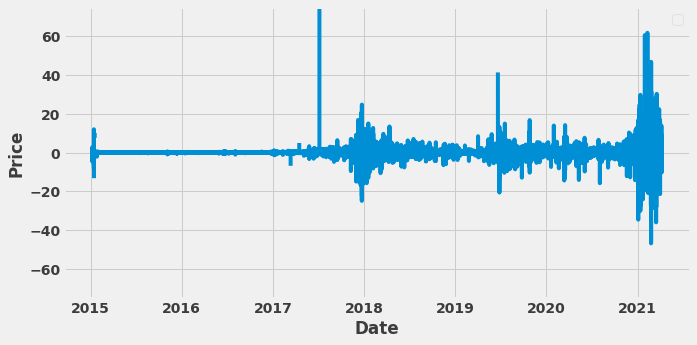

In [ ]:
#Data

df_hour["hourly_diff"] = df_hour["Close"] - df_hour["Open"]

#Plot
ax, fig = plt.subplots(figsize = (10,5))

plt.plot(df_hour["hourly_diff"])

plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.ylim(-75, 75)

plt.xlabel("Date",alpha=0.75, weight="bold")
plt.ylabel("Price",alpha=0.75, weight="bold")

plt.legend()

No handles with labels found to put in legend.


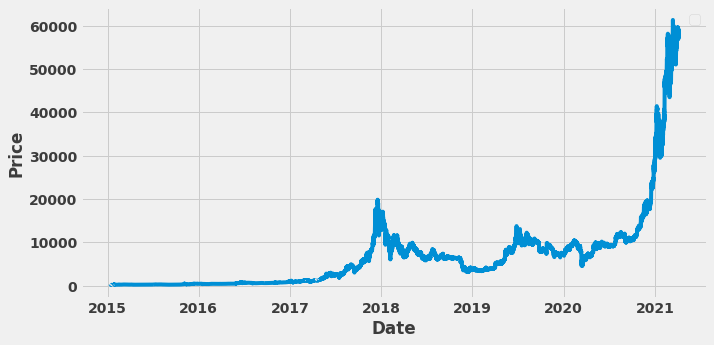

In [ ]:
ax, fig = plt.subplots(figsize = (10,5))

plt.plot(df_hour["Weighted_Price"])

plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Date",alpha=0.75, weight="bold")
plt.ylabel("Price",alpha=0.75, weight="bold")

plt.legend()

Make decomposition.

* Season 
* Trend 
* Residual 
* Level

2312

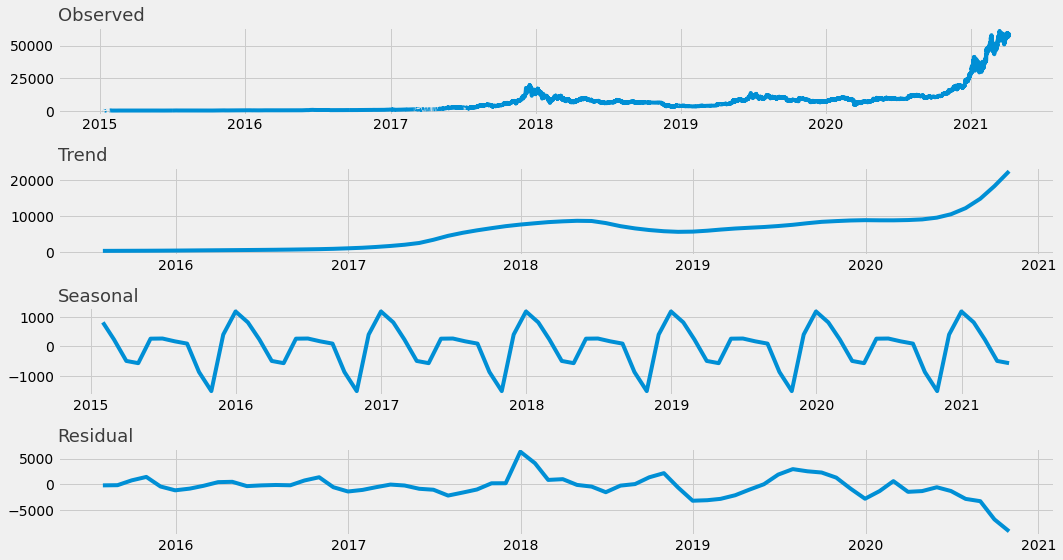

In [ ]:
#Seasonal Decompose
ax, fig = plt.subplots(figsize=(15,8), sharex=True)

df_month = df.resample("M").mean()
dec = sm.tsa.seasonal_decompose(df_month["Weighted_Price"])


plt.subplot(411)
plt.plot(df_hour["Weighted_Price"], label="Weighted Price")
plt.title("Observed",loc="left", alpha=0.75, fontsize=18)

plt.subplot(412)
plt.plot(dec.trend, label="Trend")
plt.title("Trend",loc="left", alpha=0.75, fontsize=18)

plt.subplot(413)
plt.plot(dec.seasonal, label="Seasonal")
plt.title("Seasonal",loc="left", alpha=0.75, fontsize=18)

plt.subplot(414)
plt.plot(dec.resid, label="Residual")
plt.title("Residual",loc="left", alpha=0.75, fontsize=18)
plt.tight_layout()

gc.collect()

# **Stationarity**


In [ ]:
print("Dicky-Fuller stationarity test - p: %f" % sm.tsa.adfuller(df_month["Weighted_Price"])[1])

Dicky-Fuller stationarity test - p: 0.987862


**Box-Cox**

Box-Cox comes from the family of power transformations and is often used as a mean to stabilize variance in a dataset. It is indexed by lambda and in certain times can be used as a differencing technique.

In [ ]:
#Box-Cox

df_month["Box-Cox"], _ = stats.boxcox(df_month["Weighted_Price"])
print("Dicky-Fuller stationarity test - p: %f" % sm.tsa.adfuller(df_month["Box-Cox"])[1])

Dicky-Fuller stationarity test - p: 0.943752


**Panads diff()**

Pandas library provides an option for automatic differencing with diff().

In [ ]:
#Automatic Differencing

first_diff = df_month["Weighted_Price"].diff()
print("Dicky-Fuller stationarity test - p: %f" % sm.tsa.adfuller(first_diff[1:])[1])
if (sm.tsa.adfuller(first_diff[1:])[1]) < 0.05:
    print("This series is stationary")


df_month["Auto_Diff"] = first_diff

Dicky-Fuller stationarity test - p: 0.008097
This series is stationary


Now lets plot the seasonal decomposition and AC & PAC on the stationary data so we can see the results.

10145

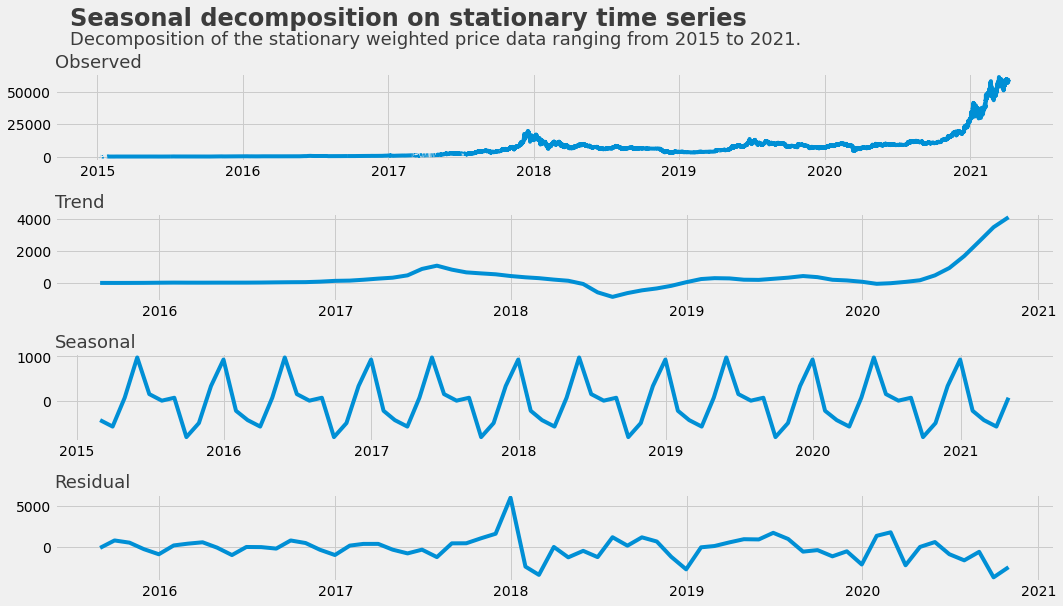

In [ ]:
#Data
seasonal_dec = sm.tsa.seasonal_decompose(df_month["Auto_Diff"][1:])

#Seasonal Decompose on stationary series
ax, fig = plt.subplots(figsize=(15,8), sharex=True)

df_month = df.resample("M").mean()
dec = sm.tsa.seasonal_decompose(df_month["Weighted_Price"])


plt.subplot(411)
plt.plot(df_hour["Weighted_Price"], label="Weighted Price")
plt.title("Observed",loc="left", alpha=0.75, fontsize=18)

plt.subplot(412)
plt.plot(seasonal_dec.trend, label="Trend")
plt.title("Trend",loc="left", alpha=0.75, fontsize=18)

plt.subplot(413)
plt.plot(seasonal_dec.seasonal, label="Seasonal")
plt.title("Seasonal",loc="left", alpha=0.75, fontsize=18)

plt.subplot(414)
plt.plot(seasonal_dec.resid, label="Residual")
plt.title("Residual",loc="left", alpha=0.75, fontsize=18)
plt.tight_layout()

plt.text(x=datetime.date(2015, 6, 30), y=63000, s="Seasonal decomposition on stationary time series",fontsize=24, weight="bold", alpha=0.75)
plt.text(x=datetime.date(2015, 6, 30), y=60700, s="Decomposition of the stationary weighted price data ranging from 2015 to 2021.",fontsize=18, alpha=0.75)

gc.collect()

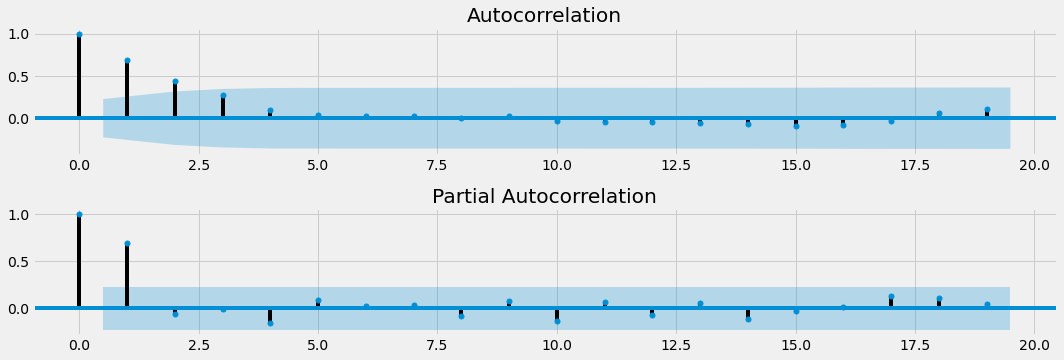

In [ ]:
ax, fig = plt.subplots(figsize=(15,10))

plt.subplot(411)
x = sm.graphics.tsa.plot_acf(first_diff[1:], ax=plt.gca())
plt.subplot(412)
y = sm.graphics.tsa.plot_pacf(first_diff[1:],ax=plt.gca())
plt.tight_layout()

gc.collect()
del x,y

# **Cross Validation**

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    errors = []

    values = data.values
    alpha, beta, gamma = x

     tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

# **SARIMAX**

In [ ]:
###SARIMAX###

#Constructs all possible parameter combinations.
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))

seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]

In [ ]:
def sarimax_function(data,pdq,s_pdq):

    """
    The function uses a brute force approach to apply all possible pdq combinations and evaluate the model
    """

    result_list = []
    for param in pdq:
        for s_param in s_pdq:

            model = sm.tsa.statespace.SARIMAX(data, order=param, seasonal_order=s_param,
            enforce_invertibility=False,enforce_stationarity=False)

            results = model.fit()
            result_list.append([param,s_param,results.aic])
            print("ARIMA Parameters: {} x: {}. AIC: {}".format(param,s_param,results.aic))

    return result_list,results

The evaluation metric for the model selection was AIC (Akaike Information Criterion -> AIC=ln (sm2) + 2m/T). 

In [ ]:
result_list,results = sarimax_function(df_month["Weighted_Price"],pdq,seasonal_pdq)

gc.collect()

ARIMA Parameters: (0, 0, 0) x: (0, 0, 0, 12). AIC: 1638.989369863388
ARIMA Parameters: (0, 0, 0) x: (0, 0, 1, 12). AIC: 1377.6195568425007
ARIMA Parameters: (0, 0, 0) x: (0, 1, 0, 12). AIC: 1359.3640763679186
ARIMA Parameters: (0, 0, 0) x: (0, 1, 1, 12). AIC: 1114.8246605975767
ARIMA Parameters: (0, 0, 0) x: (1, 0, 0, 12). AIC: 1374.6186610144466
ARIMA Parameters: (0, 0, 0) x: (1, 0, 1, 12). AIC: 1344.9769899476282
ARIMA Parameters: (0, 0, 0) x: (1, 1, 0, 12). AIC: 1133.9557762911847
ARIMA Parameters: (0, 0, 0) x: (1, 1, 1, 12). AIC: 1112.89767684853
ARIMA Parameters: (0, 0, 1) x: (0, 0, 0, 12). AIC: 1562.518987522896
ARIMA Parameters: (0, 0, 1) x: (0, 0, 1, 12). AIC: 1308.441582860384
ARIMA Parameters: (0, 0, 1) x: (0, 1, 0, 12). AIC: 1269.1538110207766
ARIMA Parameters: (0, 0, 1) x: (0, 1, 1, 12). AIC: 1046.6153855006846
ARIMA Parameters: (0, 0, 1) x: (1, 0, 0, 12). AIC: 1348.5105738034931
ARIMA Parameters: (0, 0, 1) x: (1, 0, 1, 12). AIC: 1236.0088431585455
ARIMA Parameters: (0, 0, 

29

In [ ]:
#Dataframe of all results and parameters.

results_dataframe = pd.DataFrame(result_list, columns=["dpq","s_dpq","aic"]).sort_values(by="aic")
results_dataframe.head()

,dpq,s_dpq,aic
59,"(1, 1, 1)","(0, 1, 1, 12)",914.096268
63,"(1, 1, 1)","(1, 1, 1, 12)",916.047060
27,"(0, 1, 1)","(0, 1, 1, 12)",919.267967
31,"(0, 1, 1)","(1, 1, 1, 12)",923.974080
51,"(1, 1, 0)","(0, 1, 1, 12)",927.930378


In [ ]:
model = sm.tsa.statespace.SARIMAX(df_month["Weighted_Price"], order=(0, 1, 1), seasonal_order=(1, 1, 1, 12),
            enforce_invertibility=False,enforce_stationarity=False).fit()
print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6422      0.151      4.251      0.000       0.346       0.938
ar.S.L12      -0.0656      0.266     -0.247      0.805      -0.586       0.455
ma.S.L12      -0.9075      0.336     -2.700      0.007      -1.566      -0.249
sigma2      9.126e+06   6.17e-08   1.48e+14      0.000    9.13e+06    9.13e+06


6529

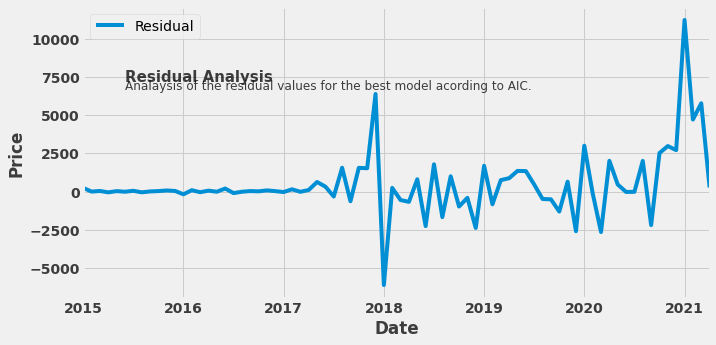

In [ ]:
#Residual analysis
ax, fig = plt.subplots(figsize = (10,5))

model.resid.plot(label="Residual")

plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Date",alpha=0.75, weight="bold")
plt.ylabel("Price",alpha=0.75, weight="bold")

plt.legend()

plt.text(x=datetime.date(2015, 6, 30), y=7200, s="Residual Analysis",
fontsize=15, weight="bold", alpha=0.75)
plt.text(x=datetime.date(2015, 6, 30), y=6700, s="Analaysis of the residual values for the best model acording to AIC.",fontsize=12, alpha=0.75)

gc.collect()

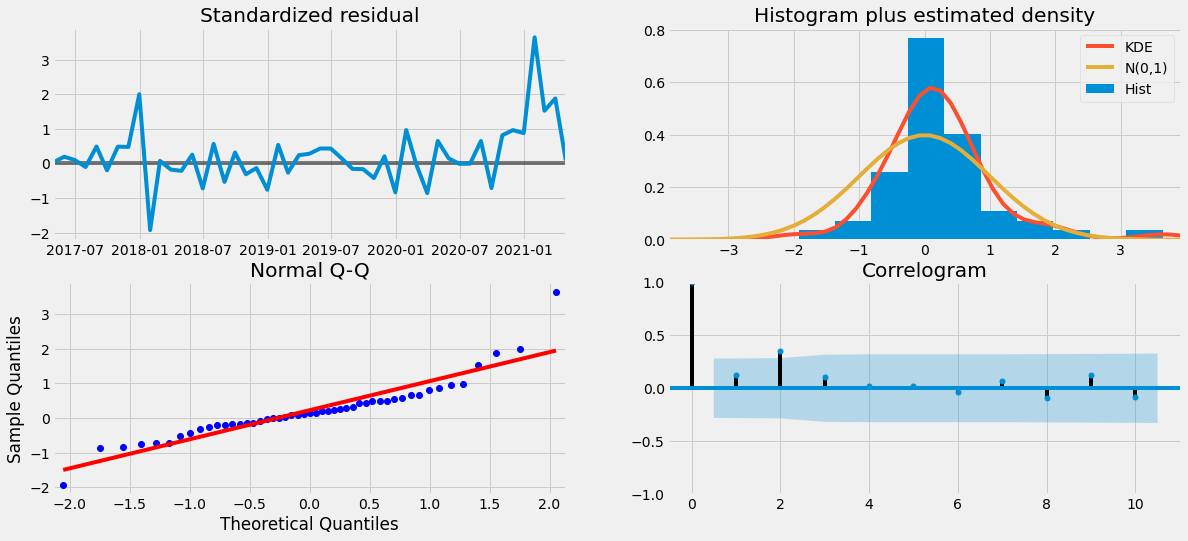

In [ ]:
x = model.plot_diagnostics(figsize=(18, 8))

gc.collect()
del x

In [ ]:
df_month_prediction = df_month[["Weighted_Price"]]
df_month_prediction["Forcasting"] = model.predict(start=pd.to_datetime("2015-01-31"), end=pd.to_datetime("2021-04-30"))

14096

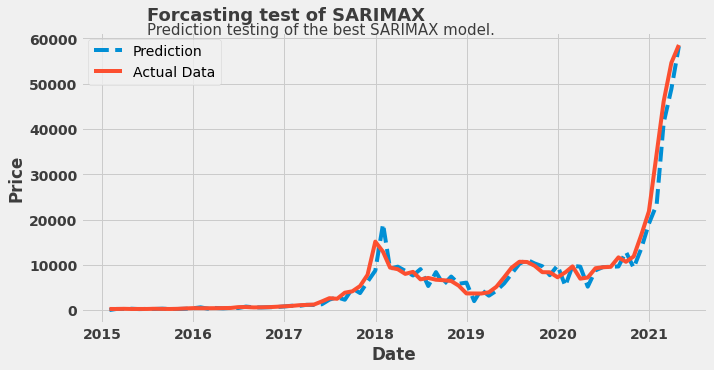

In [ ]:
ax, fig = plt.subplots(figsize = (10,5))

plt.plot(df_month_prediction["Forcasting"], ls="--", label="Prediction")
plt.plot(df_month_prediction["Weighted_Price"], label="Actual Data")

plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Date",alpha=0.75, weight="bold")
plt.ylabel("Price",alpha=0.75, weight="bold")

plt.legend()

plt.text(x=datetime.date(2015, 6, 30), y=64000, s="Forcasting test of SARIMAX",
fontsize=18, weight="bold", alpha=0.75)
plt.text(x=datetime.date(2015, 6, 30), y=61000, s="Prediction testing of the best SARIMAX model.",fontsize=15, alpha=0.75)

gc.collect()

In [ ]:
#Datetimeindex dates I want to predict

future_dates = [df_month_prediction.index[-1] + DateOffset(months = x)for x in range(1,12)]
future_dates = pd.to_datetime(future_dates)  +  MonthEnd(0)
future = pd.DataFrame(index=future_dates)
df_month_prediction = pd.concat([df_month_prediction,future])

gc.collect()

50

In [ ]:
#Prediction

df_month_prediction["Future_forcast"] = model.predict(start=pd.to_datetime("2021-04-30"),end=pd.to_datetime("2022-04-30"))

pred = model.get_prediction(start=pd.to_datetime("2020-03-31"),end=pd.to_datetime("2021-03-31"))
pred_ci = pred.conf_int()

gc.collect()

72

3109

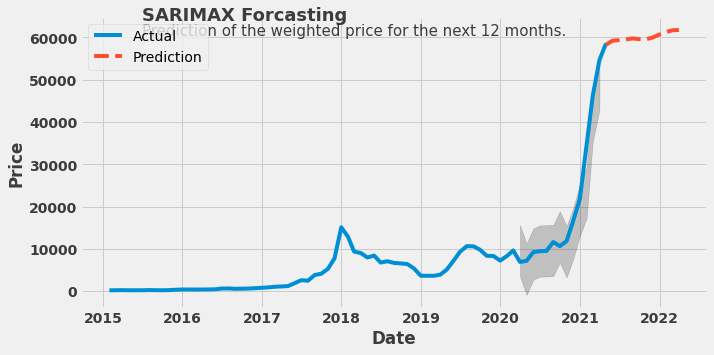

In [ ]:
ax, fig = plt.subplots(figsize=(10,5))

plt.plot(df_month_prediction["Weighted_Price"], label="Actual")
plt.plot(df_month_prediction["Future_forcast"],ls="--", label="Prediction")

plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()


plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Date",alpha=0.75, weight="bold")
plt.ylabel("Price",alpha=0.75, weight="bold")

plt.legend()

plt.text(x=datetime.date(2015, 6, 30), y=64000, s="SARIMAX Forcasting",
fontsize=18, weight="bold", alpha=0.75)
plt.text(x=datetime.date(2015, 6, 30), y=60500, s="Prediction of the weighted price for the next 12 months.",fontsize=15, alpha=0.75)

gc.collect()